results/answers at the bottom

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#from discussion 4
class PoissonProcess():
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.simulate()
        
    def simulate(self, method='inter_arrival_time'):
        if method == 'inter_arrival_time':
            N = int(self.lam * self.T * 1.3)
            inter_ls = np.random.exponential(1/self.lam, size=N) 
            arrival_time_ls = np.cumsum(inter_ls)
            self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]
            self.inter_ls = inter_ls
        if method == 'uniformity_property':
            N = np.random.poisson(self.T * self.lam)
            arrival_time_ls = np.random.uniform(0, self.T, size=N)
            self.arrival_time_ls = np.sort(arrival_time_ls)
            
    def get_arrival_time(self):
        return self.arrival_time_ls
    
    def print_parameter(self):
        print('lambda = {}, T = {}'.format(self.lam, self.T))
    
    def N_t(self, t):
        assert t >= 0
        assert t <= self.T
        if t == 0:
            return 0
        else:
            return np.argmax(self.arrival_time_ls > t)


example for single day:


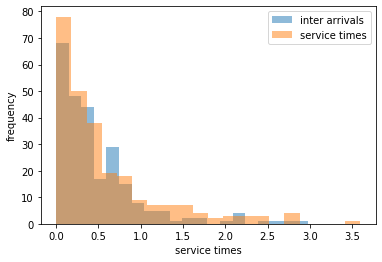

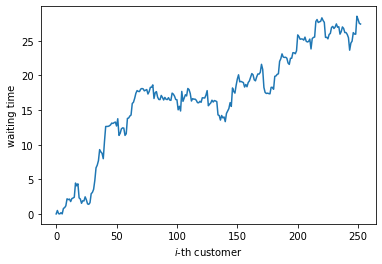

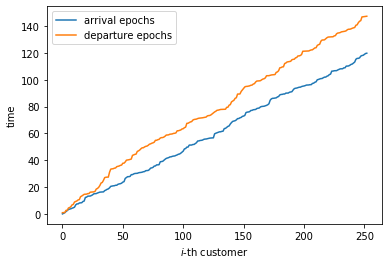

In [4]:
class day():
    def __init__(self, arrival_lam, service_lam, T):
        self.simulator(arrival_lam, service_lam, T)
        self.wait_times = []
        self.departure_epochs = []
        self.inter_arrivals = [] #for plotting purposes
        
    #note to self: wait time for customer i is defined as the time between i's arrival and when the 
    #   store starts working on their order (their order takes service_time[i] time to complete). 
    #   The first customer has wait time of 0 because the store immediately starts working on their order
    def simulator(self, arrival_lam, service_lam, T):
        arrivals = PoissonProcess(arrival_lam, T)
        self.arrival_epochs = arrivals.arrival_time_ls
        self.service_times = np.random.exponential(1/service_lam, size=len(self.arrival_epochs))

    def calc_waits(self, start_index=0):
        if start_index > 0:
            wait_times = self.wait_times[:start_index]
            departure_epochs = self.departure_epochs[:start_index]
            inter_arrivals = self.inter_arrivals[:start_index]
        else:
            wait_times = self.wait_times
            departure_epochs = self.departure_epochs
            inter_arrivals = self.inter_arrivals
        for i in range(len(self.arrival_epochs)):
            i += start_index
            if i >= len(self.arrival_epochs):
                break
            if i == 0:
                wait = 0
                inter_arrival_time = self.arrival_epochs[i]
            if i >= 1:
                inter_arrival_time = self.arrival_epochs[i] - self.arrival_epochs[i-1]
                x1 = wait_times[i-1]
                x2 = self.service_times[i-1]
                wait = max(0, x1 + x2 - inter_arrival_time)
            wait_times.append(wait)
            departure_epochs.append(self.arrival_epochs[i] + wait + self.service_times[i])
            inter_arrivals.append(inter_arrival_time)
        self.wait_times = wait_times
        self.departure_epochs = departure_epochs
        self.inter_arrivals = inter_arrivals

    def plot(self):
        print()
        print("example for single day:")
        plt.figure(0)
        plt.hist(self.inter_arrivals, bins=20, alpha=0.5, label='inter arrivals')
        plt.hist(self.service_times, bins=20, alpha=0.5, label='service times')
        plt.xlabel('service times')
        plt.ylabel('frequency')
        plt.legend()

        plt.figure(1)
        plt.plot(self.wait_times)
        plt.xlabel('$i$-th customer')
        plt.ylabel('waiting time')
        
        plt.figure(2)
        plt.plot(self.arrival_epochs, label='arrival epochs')
        plt.plot(self.departure_epochs, label='departure epochs')
        plt.xlabel('$i$-th customer')
        plt.ylabel('time')
        plt.legend()
        
example = day(2, 60/35, 120)
example.calc_waits()
example.plot()

In [7]:
def part_i():
    ans = []
    for day in fifty_days:
        day.calc_waits()
        for i in range(len(day.arrival_epochs)):
            t = day.arrival_epochs[i]
            if t < 15:
                continue
            if t > 30:
                break
            ans.append(day.wait_times[i])
    print('answer for part i: ', sum(ans)/len(ans))


In [8]:
def part_ii():
    ans = []
    for day in fifty_days:
        for i in range(len(day.arrival_epochs)):
            t = day.arrival_epochs[i]
            if t < 105:
                continue
            ans.append(day.wait_times[i])
    print('answer for part ii: ', sum(ans)/len(ans))

In [9]:
def part_iv():
    long_waits1 = 0
    total_customers1 = 0

    long_waits2 = 0
    total_customers2 = 0
    for day in fifty_days:
        for i in range(len(day.arrival_epochs)):
            t = day.arrival_epochs[i]
            if t < 15 or (t > 30 and t < 105):
                continue
            if t <= 30:
                total_customers1 += 1
                if day.wait_times[i] > 3:
                    long_waits1 += 1
            if t >= 105:
                total_customers2 += 1
                if day.wait_times[i] > 3:
                    long_waits2 += 1
    print('answers for part iv: ')
    print('11:15 - 11:30: ', 100 * long_waits1/total_customers1)
    print('12:45 - 1:00: ', 100 * long_waits2/total_customers2)

In [10]:
def part_v():
    abandon_rates = 0
    exp_wait_times = 0
    for day in fifty_days:
        abandoners = [] #12:45 - 1:00
        customer_count = 0 #12:45 - 1:00
        #first, recalculate the wait times given the new customer behavior
        n = len(day.arrival_epochs)
        for i in range(n):
            i_arrival = day.arrival_epochs[i]
            if i_arrival >= 105:
                customer_count += 1
            for j in range(n):
                j_departure = day.departure_epochs[j]
                if j_departure >= i_arrival:
                    if i - j > 5:
                        day.service_times[i] = 0
                        day.calc_waits(i+1)
                        if i_arrival >= 105:
                            abandoners.append(i)
                        break
        abandon_rates += len(abandoners)/customer_count

        non_abandon_waits = []
        for i in range(n):
            if day.arrival_epochs[i] >= 105:
                if i not in abandoners:
                    non_abandon_waits.append(day.wait_times[i])
        exp_wait_times += sum(non_abandon_waits)/len(non_abandon_waits)
    print("answers for part v:")
    print("% of customers who abandon 12:45 - 1:00 ", 100 * abandon_rates/50)
    print("expected waiting time for non-abandoners 12:45 - 1:00 ", exp_wait_times/50)
        

In [14]:
fifty_days = []
for i in range(500):
    fifty_days.append(day(2, 60/35, 120))
part_i()
part_ii()
print()
part_iv()
print()
part_v()

answer for part i:  6.279770879689021
answer for part ii:  22.06714268306232

answers for part iv: 
11:15 - 11:30:  70.91577540106952
12:45 - 1:00:  97.4267908597467

answers for part v:
% of customers who abandon 12:45 - 1:00  313.28580852975205
expected waiting time for non-abandoners 12:45 - 1:00  12.686427828597482


In [13]:
print("Part vi:")
print()
fifty_days = []
for i in range(50):
    fifty_days.append(day(2, 60/30, 120))
part_i()
part_ii()
print()
part_iv()
print()
part_v()

Part vi:

answer for part i:  3.82934125521964
answer for part ii:  7.98412235316545

answers for part iv: 
11:15 - 11:30:  52.46835443037975
12:45 - 1:00:  76.23056994818653

answers for part v:
% of customers who abandon 12:45 - 1:00  22.40799810116867
expected waiting time for non-abandoners 12:45 - 1:00  0.9523744437458815
